# Write an introduction here 

In [18]:
#Imports 
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sliderule import sliderule, icesat2, earthdata, h5
from shapely import wkt
from shapely.geometry import Point, LineString, shape
from scipy.spatial.distance import cdist
import itertools
import warnings 
warnings.filterwarnings("ignore")

from ROIhelpertools import triangle_maximum_angle, find_closest_point, find_angle

# Fancier plotting tools (we might need this later?)
#from cartopy import crs
#import geoviews as gv
#import geoviews.feature as gf
#from geoviews import dim, opts
#import geoviews.tile_sources as gts
#from bokeh.models import HoverTool
#gv.extension('bokeh')

## 1. Initialise SlideRule

In [5]:
# Initialize SlideRule
icesat2.init("slideruleearth.io")

In [6]:
earthdata.set_max_resources(2000)

## 2. Import data 



In [7]:
# Read in Grounding line(GL) file and Polygon of 120m buffer around GL
GL = gpd.read_file('Kamb_GL_short_line.geojson')
GL = GL.to_crs('EPSG:3031')
buffer120m = gpd.read_file('Kamb_GL_buffer120m_short.geojson')
buffer5km= gpd.read_file('Kamb_GL_buffer5km_short.geojson')
#buffer5km = buffer5km.to_crs('EPSG:3031')
buffer120m_SR = sliderule.toregion('Kamb_GL_buffer120m_short.geojson')["poly"]
buffer5km_SR = sliderule.toregion('Kamb_GL_buffer5km_short.geojson')["poly"]

In [8]:
# Get IS2 data within 120m GL buffer (uses a convex hull)

# Define parameters
parms = {
    "poly": buffer5km_SR,
    "srt": 3,
    #"cnf": icesat2.CNF_SURFACE_HIGH,
    #"ats": 5.0,
    "len": 40.0,
    "res": 20.0,
    "maxi": 5,
    "t0": '2019-03-29T00:00:00Z'
}

# Calculated ATL06 dataframe
is2_df = icesat2.atl06p(parms, "nsidc-s3")

# Display top of the ICESat-2 dataframe
is2_df.head()
is2_all_data = is2_df
is2_all_data = is2_all_data.to_crs('EPSG:3031')

In [9]:
# Clip to boundary 
is2_df = is2_df.clip(buffer120m)
# Convert to a more suitable projection: 
is2_df = is2_df.to_crs('EPSG:3031')

<AxesSubplot: title={'center': 'SlideRule Zoomed Ground Tracks'}>

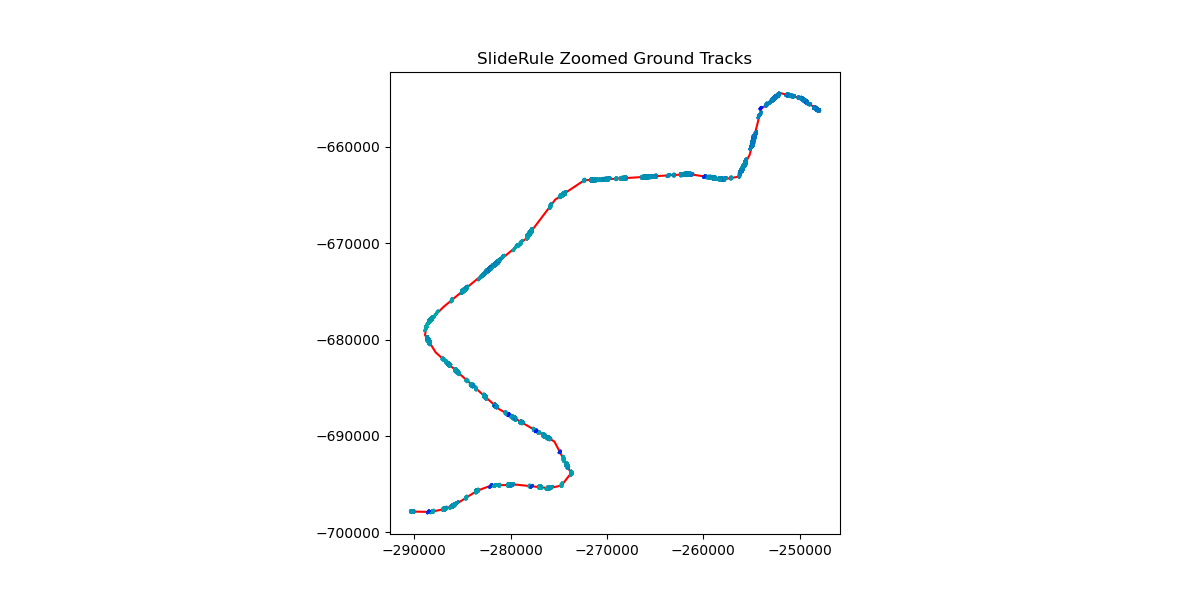

In [7]:
#Plot location of tracks

%matplotlib widget
# Create Plot
fig,ax1 = plt.subplots(1, figsize=(12, 6))

# Plot SlideRule Ground Tracks
ax1.set_title("SlideRule Zoomed Ground Tracks")
ROI = is2_df.plot(ax=ax1, column=is2_df["h_mean"], s=1.0, zorder=3, cmap='winter_r', vmin=-20, vmax=90)
GL.plot(ax=ax1, color='r')

In [10]:
is2_df_subset = is2_df[(is2_df['rgt']==404) & (is2_df['spot']==6) & (is2_df['cycle']==5)]
is2_df_subset

,rms_misfit,spot,h_sigma,gt,rgt,dh_fit_dx,dh_fit_dy,cycle,w_surface_window_final,h_mean,n_fit_photons,pflags,segment_id,distance,geometry
time,,,,,,,,,,,,,,,
2019-10-23 09:30:19.673268480,0.000000,6,0.000000,10,404,-0.091838,0.0,5,6.418596,40.444086,129,2,1539037,3.079451e+07,POINT (-249190.838 -655280.669)
2019-10-23 09:30:19.676086528,0.419099,6,0.065494,10,404,-0.024618,0.0,5,6.415774,35.440013,75,0,1539038,3.079453e+07,POINT (-249191.613 -655300.069)
2019-10-23 09:30:19.678906112,0.507011,6,0.046285,10,404,-0.005766,0.0,5,6.484097,35.163531,120,0,1539039,3.079455e+07,POINT (-249192.434 -655319.467)
2019-10-23 09:30:19.681726208,0.473977,6,0.046641,10,404,-0.000303,0.0,5,6.426429,35.130585,105,0,1539040,3.079457e+07,POINT (-249193.269 -655338.864)
2019-10-23 09:30:19.684544768,0.782236,6,0.081127,10,404,0.000002,0.0,5,8.965407,34.970425,93,4,1539041,3.079459e+07,POINT (-249194.120 -655358.260)
2019-10-23 09:30:19.687366144,1.909169,6,0.597698,10,404,-0.503174,0.0,5,12.845503,42.623426,28,0,1539042,3.079461e+07,POINT (-249195.049 -655377.653)
2019-10-23 09:30:19.690183680,0.000000,6,0.000000,10,404,-0.024551,0.0,5,3.000000,41.757163,142,2,1539043,3.079463e+07,POINT (-249195.937 -655397.048)
2019-10-23 09:30:19.693000448,0.232998,6,0.026822,10,404,-0.001494,0.0,5,6.607640,34.729663,87,0,1539044,3.079465e+07,POINT (-249196.787 -655416.444)
2019-10-23 09:30:19.695819520,0.157541,6,0.024579,10,404,-0.009810,0.0,5,5.388375,34.632473,72,0,1539045,3.079467e+07,POINT (-249197.689 -655435.838)


<AxesSubplot: title={'center': 'SlideRule Zoomed Ground Tracks'}>

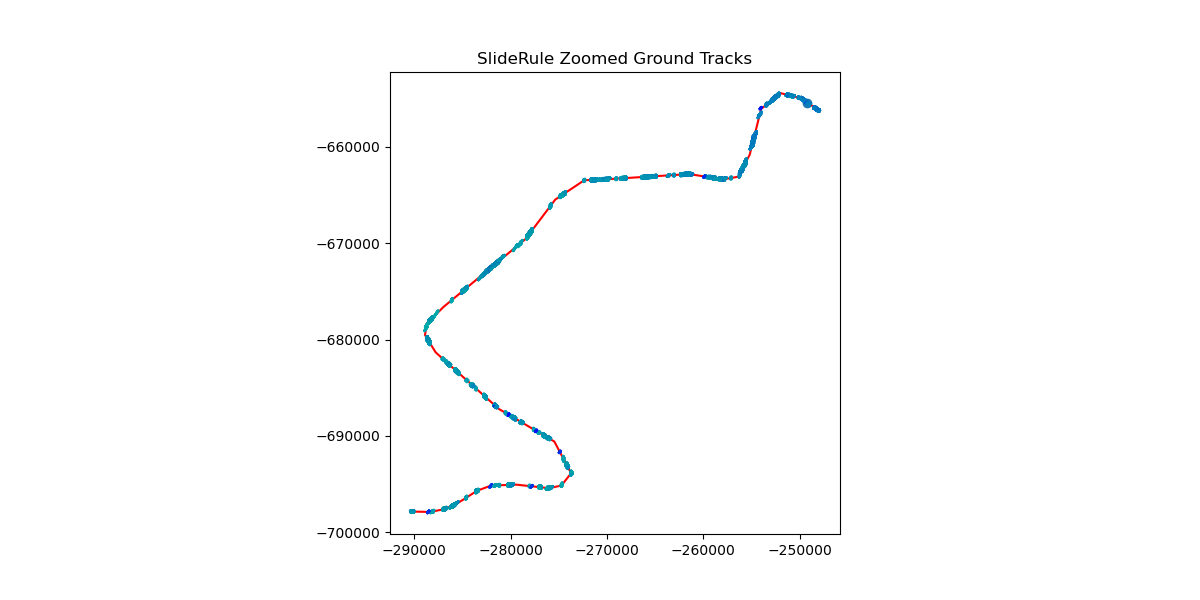

In [217]:
# Convert to line: 

is2_line = LineString(is2_df_subset['geometry'])

# Here stats the function
intersection = is2_line.intersection(GL.geometry)

%matplotlib widget
# Create Plot
fig,ax1 = plt.subplots(1, figsize=(12, 6))

# Plot SlideRule Ground Tracks
ax1.set_title("SlideRule Zoomed Ground Tracks")
ROI = is2_df.plot(ax=ax1, column=is2_df["h_mean"], s=1.0, zorder=3, cmap='winter_r', vmin=-20, vmax=90)
GL.plot(ax=ax1, color='r')
intersection.plot(ax=ax1)

In [159]:
GL_exploded = GL.explode(index_parts=True)
GL_nodes = np.column_stack(GL_exploded.geometry.iloc[0].coords.xy)
is2_points = np.column_stack([np.array(is2_df_subset.geometry.x), np.array(is2_df_subset.geometry.y)])

# Location of intersection points: 
x0, y0 = intersection.geometry.iloc[0].coords.xy
                                                                                                     
idx_GL = np.argmin(cdist([(x0[0], y0[0])], GL_nodes,  metric = 'euclidean')) 
closest_GL_node = GL_nodes[idx_GL]

idx_is2 = np.argmin(cdist([(x0[0], y0[0])], is2_points,  metric = 'euclidean')) 
closest_is2_point = is2_points[idx_is2]
print(closest_GL_node, closest_is2_point)

[-257926.6659155  -663382.31680058] [-258768.18255943 -663259.01196878]


## 3. Select only tracks that are close to perpendicular to the GL

In [13]:
ids = 1
intersect_id = pd.DataFrame(columns = ['id','rgt', 'spot','x','y', 'angle'])
accepted_is2 = pd.DataFrame(columns = is2_all_data.columns.tolist()+['dti'])
for rgt, spot in itertools.product(is2_df.rgt.unique(), is2_df.spot.unique()):
    #print(rgt, spot)
    is2_df_subset = is2_df[(is2_df['rgt']==rgt) & (is2_df['spot']==spot) & (is2_df['cycle']==3)]
    
    if np.size(is2_df_subset, axis = 0) >= 2:
        #print(is2_df_subset)
        x0,y0, max_angle = find_angle(is2_df_subset.geometry, GL)
        
        if (max_angle >= 80) and (max_angle <= 100): 
            #Make the 
            intersect_id.loc[len(intersect_id.index)]=[ids,rgt, spot, x0,y0, max_angle]
            ids+=1
            
            #is2_subset_points = np.column_stack([np.array(is2_subset.geometry.x), np.array(is2_subset.gemoetry.y)])
            subset_all_data = is2_all_data[(is2_all_data['rgt']==rgt) & (is2_all_data['spot']==spot)]
            
            # Compute the distance to the intersection point: 
            is2_subset_points = np.column_stack([np.array(subset_all_data.geometry.x), np.array(subset_all_data.geometry.y)])
            subset_all_data['dti'] = cdist([(x0, y0)], is2_subset_points,  metric = 'euclidean')[0]
            accepted_is2 = accepted_is2.append(subset_all_data[subset_all_data['dti'] <= 5000])
        

In [71]:
# Convert to a GeoDataFrame
accepted_is2 = gpd.GeoDataFrame(accepted_is2, geometry='geometry', crs="EPSG:3031")
type(accepted_is2)

geopandas.geodataframe.GeoDataFrame

In [33]:
#accepted_is2 = accepted_is2.append(subset_all_data[subset_all_data['dti'] <= 5000])
#accepted_is2

/tmp/ipykernel_362/185667603.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accepted_is2 = accepted_is2.append(subset_all_data[subset_all_data['dti'] <= 5000])


,rms_misfit,h_sigma,segment_id,w_surface_window_final,h_mean,pflags,rgt,spot,cycle,distance,gt,dh_fit_dx,dh_fit_dy,n_fit_photons,geometry,dti
2019-05-11 17:11:51.632867072,0.197933,0.018271,1541607,3.000000,41.247072,0,663,4,3,3.084557e+07,40,-0.002891,0.0,119,POINT (-286525.197 -692652.123),4981.022536
2019-05-11 17:11:51.635694336,0.171844,0.015080,1541608,3.000000,41.242430,0,663,4,3,3.084559e+07,40,0.001822,0.0,131,POINT (-286526.941 -692671.471),4961.596969
2019-05-11 17:11:51.638522368,0.144036,0.012666,1541609,3.000000,41.231387,0,663,4,3,3.084561e+07,40,-0.001458,0.0,130,POINT (-286528.695 -692690.817),4942.171400
2019-05-11 17:11:51.641349120,0.195022,0.018030,1541610,3.000000,41.195492,0,663,4,3,3.084563e+07,40,-0.000759,0.0,117,POINT (-286530.458 -692710.162),4922.745828
2019-05-11 17:11:51.644175616,0.261497,0.023999,1541611,3.000000,41.185685,0,663,4,3,3.084565e+07,40,-0.000698,0.0,119,POINT (-286532.234 -692729.507),4903.320254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-04 21:50:14.344724736,0.000000,0.000000,1541864,3.000000,31.357958,2,663,4,13,3.085068e+07,40,0.010931,0.0,345,POINT (-286951.923 -697626.405),26.937996
2021-11-04 21:50:14.347546880,0.793319,0.230102,1541865,11.523386,30.785330,0,663,4,13,3.085070e+07,40,0.028261,0.0,12,POINT (-286953.665 -697645.754),39.361699
2021-11-04 21:50:14.350362112,0.000000,0.000000,1541866,3.553953,31.274456,2,663,4,13,3.085072e+07,40,0.021032,0.0,10,POINT (-286955.380 -697665.104),55.938392
2021-11-04 21:50:14.353167104,5.635524,0.678441,1541867,30.000000,30.440231,0,663,4,13,3.085074e+07,40,-0.398464,0.0,73,POINT (-286957.042 -697684.460),73.934043


<AxesSubplot: title={'center': 'SlideRule Zoomed Ground Tracks'}>

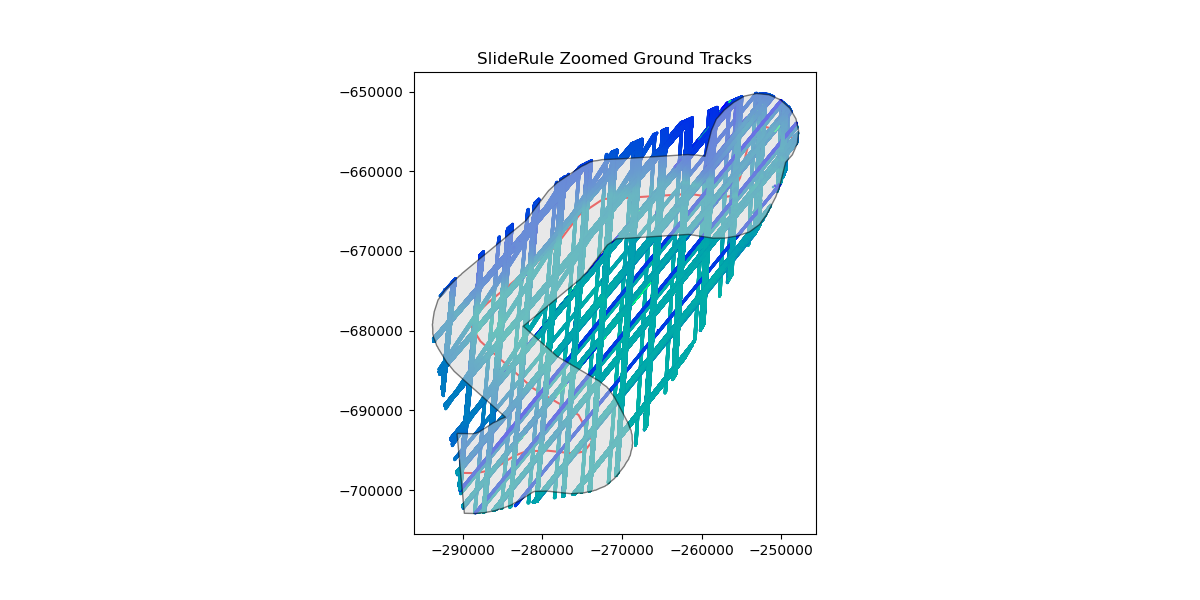

In [21]:
%matplotlib widget
# Create Plot
fig,ax1 = plt.subplots(1, figsize=(12, 6))

# Plot SlideRule Ground Tracks
ax1.set_title("SlideRule Zoomed Ground Tracks")
#ROI =  vmin=-20, vmax=90)
ROI = is2_all_data.plot(ax=ax1, column=is2_all_data["h_mean"], s=1.0, zorder=3, cmap='winter_r', vmin=-20, vmax=90)
GL.plot(ax=ax1, color='r')
buffer5km.to_crs('EPSG:3031').plot(ax=ax1, edgecolor='k', facecolor="lightgrey", alpha = 0.5, zorder = 100)
#ax1.plot(x0,y0,markersize = 100, c='g')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

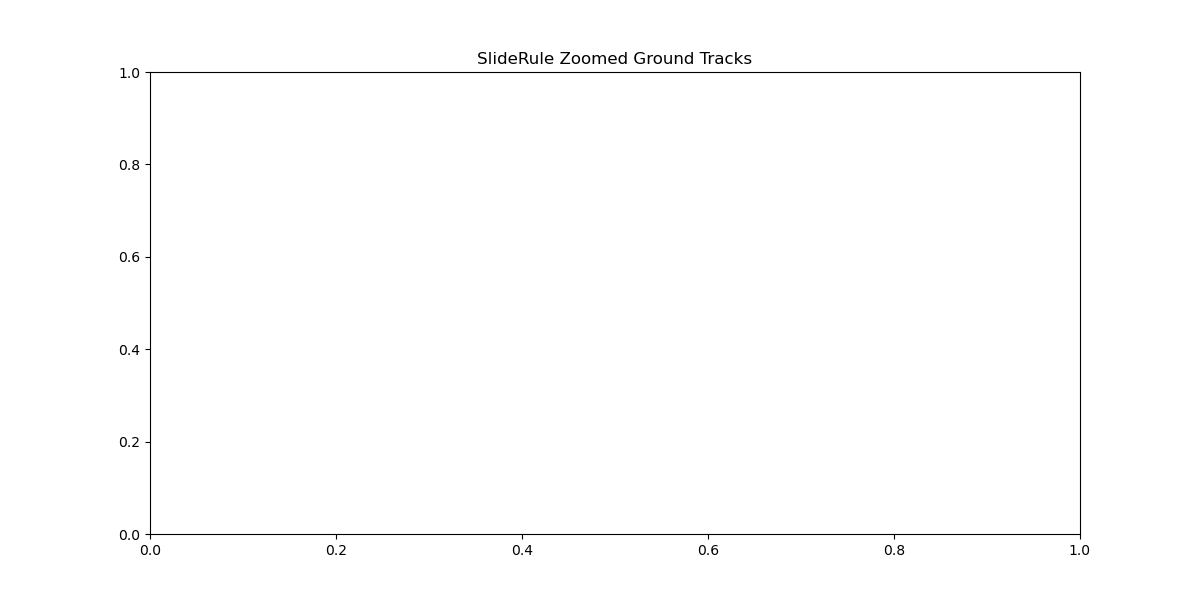

In [22]:
#accepted_is2.plot(column = 'h_mean')
fig,ax1 = plt.subplots(1, figsize=(12, 6))

# Plot SlideRule Ground Tracks
ax1.set_title("SlideRule Zoomed Ground Tracks")
#ROI =  vmin=-20, vmax=90)
ROI = accepted_is2.plot(ax=ax1, column=accepted_is2["h_mean"], s=1.0, zorder=3, cmap='winter_r', vmin=-20, vmax=90)
GL.plot(ax=ax1, color='r')
#ax1.plot(x0,y0,markersize = 100, c='g')
selected = subset_all_data[subset_all_data['dti'] <= 5000]
buffer5km.to_crs('EPSG:3031').plot(ax=ax1, edgecolor='k', facecolor="lightgrey", alpha = 0.7)
#accepted_is2.plot(ax=ax1, column=accepted_is2["h_mean"])

In [78]:
buffer5km.to_crs('EPSG:3031').plot(ax=ax1, color='r', facecolor="none")

<AxesSubplot: title={'center': 'SlideRule Zoomed Ground Tracks'}>

In [36]:
accepted_is2['h_mean'].head()

2019-05-27 16:38:21.073503488    34.488833
2019-05-27 16:38:21.076335872    34.442240
2019-05-27 16:38:21.079169280    34.280361
2019-05-27 16:38:21.082001152    34.181664
2019-05-27 16:38:21.084832512    34.068933
Name: h_mean, dtype: float64

<AxesSubplot: title={'center': 'SlideRule Zoomed Ground Tracks'}>

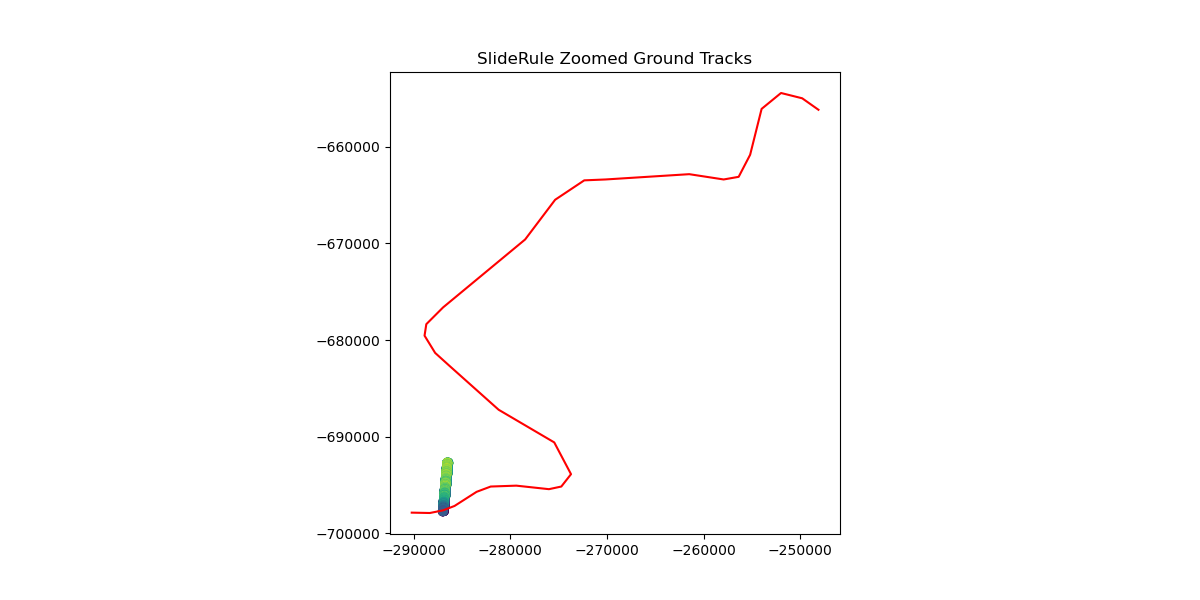

In [25]:
#accepted_is2.plot(column = 'h_mean')
fig,ax1 = plt.subplots(1, figsize=(12, 6))

# Plot SlideRule Ground Tracks
ax1.set_title("SlideRule Zoomed Ground Tracks")
#ROI =  vmin=-20, vmax=90)
#ROI = is2_all_data.plot(ax=ax1, column=is2_all_data["h_mean"], s=1.0, zorder=3, cmap='winter_r', vmin=-20, vmax=90)
GL.plot(ax=ax1, color='r')
#ax1.plot(x0,y0,markersize = 100, c='g')
selected = subset_all_data[subset_all_data['dti'] <= 5000]
selected.plot(ax=ax1, column=selected["h_mean"])